In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

train_data1 = np.load('data0.npy')
train_lab1 = np.load('lab0.npy')
train_data2 = np.load('data1.npy')
train_lab2 = np.load('lab1.npy')
train_data3 = np.load('data2.npy')
train_lab3 = np.load('lab2.npy')

train_data = np.concatenate([train_data1, train_data2, train_data3], axis=0)
train_labels = np.concatenate([train_lab1, train_lab2, train_lab3], axis=0)

train_data = train_data.astype(np.float32) / 255.0
train_labels = train_labels.astype(np.float32)

train_data = torch.tensor(train_data).unsqueeze(1)
train_labels = torch.tensor(train_labels)

batch_size = 64
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class SumOfDigitsPredictor(nn.Module):
    def __init__(self, trained_model):
        super(SumOfDigitsPredictor, self).__init__()
        # Use the conv_layers from the trained model
        self.conv_layers = trained_model.conv_layers
        
        # New head for sum prediction
        self.sum_head = nn.Sequential(
            nn.Linear(5120, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Single output for sum of digits
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sum_head(x)
        return x
    
class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 28 x 28
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 14 x 14
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 7 x 7
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256 x 3 x 3
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5120, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 30),  # 10 outputs for multi-label (digits 0-9)
            nn.Sigmoid()  # Use Sigmoid for multi-label classification
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

C:\Users\madha\AppData\Local\Temp\ipykernel_8224\1967123990.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("digit_recognizer.pt

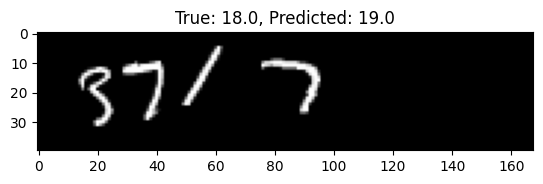

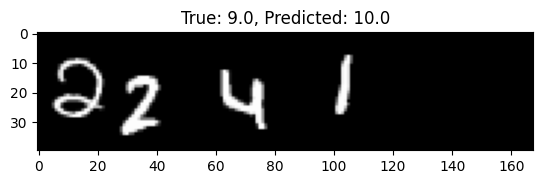

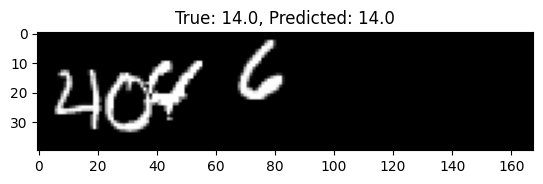

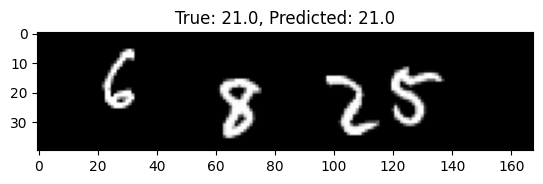

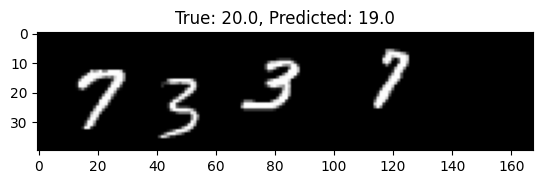

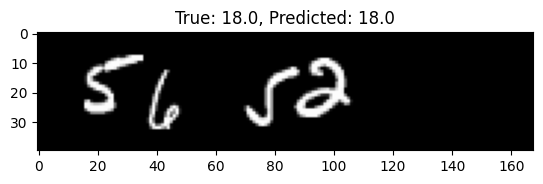

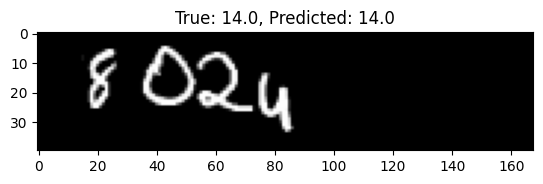

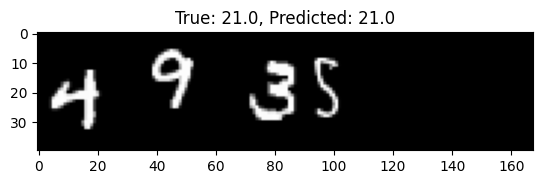

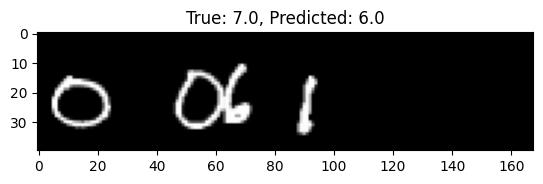

Accuracy: 69.79%


In [7]:
correct = 0
total = 0
i=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = MultiLabelCNN()
trained_model.load_state_dict(torch.load("digit_recognizer.pth"))
model = SumOfDigitsPredictor(trained_model=trained_model)
#Load Model and Find Accuracy
model.load_state_dict(torch.load("sum_predictor_model.pth"))
model.eval()
model.to(device)
with torch.no_grad():
    for inputs2, labels2 in dataloader:
        i+=1
        inputs, labels = inputs2.to(device), labels2.to(device)
        outputs = model(inputs).squeeze()
        predicted = torch.round(outputs)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        if i % 50 == 0: 
            img = inputs[0].cpu().squeeze().numpy()  
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {labels[0].item()}, Predicted: {predicted[0].item()}")
            plt.show()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")